In [8]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt

from evaluation import evaluate
from helpers.data_loader import get_base_paths, get_repo_path

import os
import glob

In [9]:
base_paths = get_base_paths(results=True)[0]

In [10]:
def median_smoother(df, win_seconds, column='pred'):
    median_obs = np.zeros(len(df))

    for i in range(len(df)):
        median_obs[i] = df.filter(pl.col('time').is_between(df['time'][i] - win_seconds / 2, df['time'][i] + win_seconds / 2))[column].median()

    df = df.with_columns(pl.Series(name=f"{column}_median", values=median_obs))

    return df

In [11]:
def get_results_paths(method, dataset, window_size=20, subject = None, ct = False):
    
    if dataset == 'nightbeatdb':
        base_paths = get_base_paths(results=True)[0]
    else:
        base_paths = get_base_paths(results=True)[1]
    
    string = f'{method}'

    if ct:
        string += '_ct'

    # if median_filter_win is not None:
    #     string += f'_{median_filter_win}'

    string += f'_{dataset}*'

    if subject is not None:
        string += f'_{subject}_*'

    string += f'preds{window_size}.parquet'

    # print(f"search for {os.path.join(base_paths, string)}")

    return glob.glob(os.path.join(base_paths, string))

In [12]:
def evaluate_all_paths(paths, top_quality = 0):
    
    eval_dict = {}
    
    for path in paths:
        pred_df = pl.read_parquet(path)

        pred_df = pred_df.filter(pl.col('label').fill_nan(None).is_not_null())
        pred_df = pred_df.filter(pl.col('pred').fill_nan(None).is_not_null())
        
        if len(pred_df) == 0:
            continue

        orig_length = pred_df.shape[0]

        if 'quality' in pred_df.columns:
            
            remove_thresh = np.percentile(pred_df['quality'].to_numpy(), 100*(1-top_quality))
            pred_df = pred_df.filter(pl.col('quality') <= remove_thresh)
            
            # print(f"Removed {(orig_length - pred_df.shape[0])/orig_length * 100:.2f}% of {orig_length} samples")

        eval_dict[path] = evaluate(pred_df['label'], pred_df['pred'])
    
    MAE = np.mean([eval_dict[path]['MAE'] for path in eval_dict.keys()])
    MAE_sd = np.std([eval_dict[path]['MAE'] for path in eval_dict.keys()])
    MSE = np.mean([eval_dict[path]['MSE'] for path in eval_dict.keys()])
    MSE_sd = np.std([eval_dict[path]['MSE'] for path in eval_dict.keys()])
    RMSE = np.mean([eval_dict[path]['RMSE'] for path in eval_dict.keys()])
    RMSE_sd = np.std([eval_dict[path]['RMSE'] for path in eval_dict.keys()])
    Corr = np.mean([eval_dict[path]['Corr'] for path in eval_dict.keys()])
    Corr_sd = np.std([eval_dict[path]['Corr'] for path in eval_dict.keys()])
    
    return {'MAE': MAE, 'MAE_sd': MAE_sd, 'MSE': MSE, 'MSE_sd': MSE_sd, 'RMSE': RMSE, 'RMSE_sd': RMSE_sd, 'Corr': Corr, 'Corr_sd': Corr_sd}, eval_dict

In [13]:
# ignore RuntimeErrors in the notebook cells below
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [ ]:
dataset = 'aw'
method = 'nightbeat'

show_plots = False

error_df = pl.DataFrame({
    'method': [],
    'dataset': [],
    'participant': [],
    'time': [],
    'pred': [],
    'true': [],
    'med': []
    }, schema={
    'method': pl.Utf8,
    'dataset': pl.Utf8,
    'participant': pl.Utf8,
    'time': pl.Float64,
    'pred': pl.Float64,
    'true': pl.Float64,
    'med': pl.Float64
    })

error_df_part = pl.DataFrame({
    'method': [],
    'dataset': [],
    'participant': [],
    'MAE': [],
    'MSE': [],
    'RMSE': [],
    'Corr': [],
    'len_perc': []
    }, schema = {
    'method': pl.Utf8,
    'dataset': pl.Utf8,
    'participant': pl.Utf8,
    'MAE': pl.Float64,
    'MSE': pl.Float64,
    'RMSE': pl.Float64,
    'Corr': pl.Float64,
    'len_perc': pl.Float64
    })

method = 'nightbeat'

for dataset in ['nightbeatdb', 'aw']:

    res_paths = get_results_paths(method = method, dataset=dataset, window_size = '20', ct=True)

    mae_list = []
    mse_list = []
    rmse_list = []
    corr_list = []
    len_list = []
    med_list = []
    part_list = []

    base_mae_list = []
    base_mse_list = []
    base_rmse_list = []
    base_corr_list = []

    time = []
    preds = []
    true = []
    participant = []

    for p in res_paths:

        pred_df = pl.read_parquet(p)
        print(f"{dataset} - {method} - {p.split('_')[-2]}", end = ' ')

        orig_len = pred_df.shape[0]

        pred_df = pred_df.filter(pl.col('quality') == 0)

        pred_df = pred_df.filter(pl.col('label').fill_nan(None).is_not_null())
        pred_df = pred_df.filter(pl.col('pred').fill_nan(None).is_not_null())

        if 'pred_peaks' in pred_df.columns:
            pred_df = pred_df.with_columns((pl.col('pred') - pl.col('pred_peaks')).abs().alias('pred_diff'))
            pred_df = pred_df.filter(pred_df['pred_diff'] < 10)

        # 5-minute median smoother: 300 seconds
        pred_df = median_smoother(pred_df, 300*100)
        pred_df = pred_df.filter((pl.col('pred') - pl.col('pred_median')).abs() < 10)
        
        if len(pred_df) == 0:
            continue
        
        eval_dict = evaluate(pred_df['label'], pred_df['pred'])
        mae_list.append(eval_dict['MAE'])
        mse_list.append(eval_dict['MSE'])
        rmse_list.append(eval_dict['RMSE'])
        corr_list.append(eval_dict['Corr'])
        len_list.append(pred_df.shape[0]/orig_len)
        part_list.append(p.split('_')[-2])
        
        base_eval_dict = evaluate(pred_df['label'], np.repeat(np.array(pred_df['pred'].mean()), len(pred_df)))
        
        base_mae_list.append(base_eval_dict['MAE'])
        base_mse_list.append(base_eval_dict['MSE'])
        base_rmse_list.append(base_eval_dict['RMSE'])
        base_corr_list.append(base_eval_dict['Corr'])
        
        time.extend(pred_df['time'].to_numpy())
        med_list.extend(pred_df['pred_median'].to_numpy())
        preds.extend(pred_df['pred'].to_numpy())
        true.extend(pred_df['label'].to_numpy())
        participant.extend([p.split('_')[-2]]*pred_df.shape[0])

        print(f"MAE: {eval_dict['MAE']:.2f}, MSE: {eval_dict['MSE']:.2f}, RMSE: {eval_dict['RMSE']:.2f}, Corr: {eval_dict['Corr']:.2f}, Len: {int(100*pred_df.shape[0]/orig_len)}%")

        os.makedirs('visualizations', exist_ok=True)

        plt.plot(pred_df['time'], pred_df['label'], '.', label = 'label')
        plt.plot(pred_df['time'], pred_df['pred'], '.', label = 'pred')
        plt.plot(pred_df['time'], pred_df['pred_peaks'], '.', label = 'peaks')
        plt.plot(pred_df['time'], pred_df['pred_median'], '.', label = 'median')
        plt.legend()
        plt.title(f"Part: {p.split('_')[-2]}, MAE: {eval_dict['MAE']:.2f}, MSE: {eval_dict['MSE']:.2f}, RMSE: {eval_dict['RMSE']:.2f}, Corr: {eval_dict['Corr']:.2f}, Len: {int(100*pred_df.shape[0]/orig_len)}%")
        plt.savefig(f"visualizations/{p.split('/')[-1].replace('.parquet', '.png')}")
        
        if show_plots:
            plt.show()
        
        plt.close()

    error_df_part = error_df_part.vstack(pl.DataFrame({
        'method': [method]*len(part_list),
        'dataset': [dataset]*len(part_list),
        'participant': part_list,
        'MAE': mae_list,
        'MSE': mse_list,
        'RMSE': rmse_list,
        'Corr': corr_list,
        'len_perc': len_list
        }))

    error_df = error_df.vstack(pl.DataFrame({
        'method': [method]*len(time),
        'dataset': [dataset]*len(time),
        'participant': participant,
        'time': time,
        'pred': preds,
        'true': true,
        'med': med_list
        }))

nightbeatdb - nightbeat - 12 MAE: 0.72, MSE: 2.92, RMSE: 1.71, Corr: 0.91, Len: 90%
nightbeatdb - nightbeat - 33 MAE: 0.58, MSE: 2.21, RMSE: 1.49, Corr: 0.97, Len: 91%
nightbeatdb - nightbeat - 40 MAE: 1.05, MSE: 7.80, RMSE: 2.79, Corr: 0.81, Len: 90%
nightbeatdb - nightbeat - 23 MAE: 1.35, MSE: 8.17, RMSE: 2.86, Corr: 0.68, Len: 84%
nightbeatdb - nightbeat - 02 MAE: 0.58, MSE: 6.08, RMSE: 2.47, Corr: 0.77, Len: 92%
nightbeatdb - nightbeat - 32 MAE: 1.09, MSE: 17.33, RMSE: 4.16, Corr: 0.50, Len: 62%
nightbeatdb - nightbeat - 13 MAE: 1.68, MSE: 12.26, RMSE: 3.50, Corr: 0.67, Len: 91%
nightbeatdb - nightbeat - 03 MAE: 0.41, MSE: 1.16, RMSE: 1.08, Corr: 0.94, Len: 85%
nightbeatdb - nightbeat - 22 MAE: 2.47, MSE: 78.92, RMSE: 8.88, Corr: -0.29, Len: 35%
nightbeatdb - nightbeat - 21 MAE: 0.66, MSE: 4.42, RMSE: 2.10, Corr: 0.52, Len: 79%
nightbeatdb - nightbeat - 00 MAE: 0.55, MSE: 2.24, RMSE: 1.50, Corr: 0.93, Len: 92%
nightbeatdb - nightbeat - 10 MAE: 0.64, MSE: 4.44, RMSE: 2.11, Corr: 0.8

In [ ]:
# After extensive cleaning of the repository, we noticed a slight increase in performance. We are not quite sure why.
error_df_part.group_by(['method', 'dataset']).agg(pl.mean([
            'MAE',
            'MSE',
            'RMSE',
            'Corr',
            'len_perc'
        ]))

method,dataset,MAE,MSE,RMSE,Corr,len_perc
str,str,f64,f64,f64,f64,f64
"""nightbeat""","""nightbeatdb""",0.77895,7.726856,2.348523,0.791557,0.861905
"""nightbeat""","""aw""",1.668322,10.59372,2.780642,0.67397,0.745159


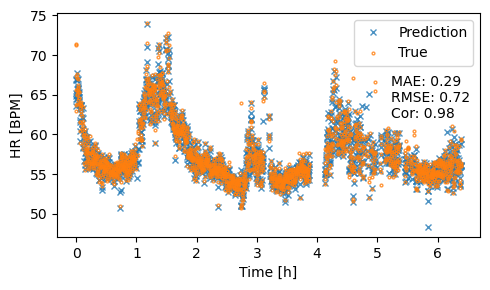

In [ ]:
# Only for when dataset is nightbeatdb and method is nightbeat
# NOTE: Somehow, performance improved for participant 11 (as well as for some other participants).
display_df = error_df.filter((pl.col('dataset') == 'nightbeatdb') & 
                (pl.col('method') == 'nightbeat') &
                (pl.col('participant') == '11'))

display_df_err = error_df_part.filter((pl.col('dataset') == 'nightbeatdb') & 
                (pl.col('method') == 'nightbeat') &
                (pl.col('participant') == '11'))

if len(display_df) > 0:
    # choose participant to display

    # visualize participant 11
    preds_s = display_df['pred'].to_numpy()
    true_s = display_df['true'].to_numpy()
    time_s = display_df['time'].to_numpy()
    time_s = (time_s - time_s[0])/360000

    part_loc = np.where(np.array(part_list) == '11')[0]

    plt.figure(figsize=(5, 3))
    plt.plot(time_s, preds_s, 'x', alpha = 0.8, label = 'Prediction', markersize=5)
    plt.plot(time_s, true_s, 'o', mfc='none', alpha = 0.8, label = 'True', markersize=2)
    plt.text(0.79, 0.53, f"MAE: {display_df_err['MAE'][0]:.2f}\nRMSE: {display_df_err['RMSE'][0]:.2f}\nCor: {display_df_err['Corr'][0]:.2f}", transform=plt.gca().transAxes)
    plt.legend()
    plt.xlabel('Time [h]')
    plt.ylabel('HR [BPM]')

    plt.tight_layout()

In [ ]:
# NOTE: After cleaning the baseline implementations too, also these results changed slightly.
for method in ['jerks', 'pwr', 'bioinsights']:
    for dataset in ['nightbeatdb', 'aw']:
        res_paths = get_results_paths(method = method, dataset=dataset)
        eval_all, eval_dict = evaluate_all_paths(res_paths, top_quality=0.23)
        print(f"{method:<12} on {dataset:<12}: MAE {eval_all['MAE']:.2f} RMSE {eval_all['RMSE']:.2f} Corr {eval_all['Corr']:.2f}")

jerks        on nightbeatdb : MAE 18.59 RMSE 25.56 Corr -0.01
jerks        on aw          : MAE 6.05 RMSE 11.33 Corr 0.34
pwr          on nightbeatdb : MAE 15.82 RMSE 17.75 Corr 0.03
pwr          on aw          : MAE 10.26 RMSE 12.08 Corr 0.17
bioinsights  on nightbeatdb : MAE 8.31 RMSE 16.28 Corr 0.09
bioinsights  on aw          : MAE 7.59 RMSE 14.79 Corr 0.14


In [19]:
# load meta file
meta = pl.read_csv(os.path.join(get_repo_path(), 'data', 'raw', 'nightbeatdb', 'meta.csv')).with_columns(pl.col('pid').map_elements(lambda x: f"{x:02d}"))

In [ ]:
# NOTE: Again, somehow, when cleaning the repository results have slightly improved
# Here, alone refers to where participants slept alone in their bed or not.
error_df_part.join(meta, left_on='participant', right_on='pid').group_by(['method', 'dataset', 'sex', 'alone']).agg([
    pl.mean('MAE').alias('MAE_mean'),
    pl.std('MAE').alias('MAE_std'),
    pl.mean('RMSE').alias('RMSE_mean'),
    pl.std('RMSE').alias('RMSE_std'),
    pl.mean('Corr').alias('Corr_mean'),
    pl.std('Corr').alias('Corr_std')
])

method,dataset,sex,alone,MAE_mean,MAE_std,RMSE_mean,RMSE_std,Corr_mean,Corr_std
str,str,str,str,f64,f64,f64,f64,f64,f64
"""nightbeat""","""nightbeatdb""","""m""","""y""",0.783378,0.513656,2.634513,2.050179,0.760238,0.343779
"""nightbeat""","""nightbeatdb""","""f""","""y""",0.6724,0.36718,1.863574,0.891858,0.869897,0.1024
"""nightbeat""","""nightbeatdb""","""m""","""n""",0.809097,0.393852,2.22197,0.959592,0.801688,0.142692
"""nightbeat""","""nightbeatdb""","""f""","""n""",0.956987,0.420316,2.677414,1.13628,0.705246,0.182685
